In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 18})

In [2]:
sns.set_style("darkgrid")

# Enunciado

Se comprime CO<sub>2</sub> isotérmicamente a 50 <sup>o</sup>C hasta una centésima parte de su volumen inicial, sabiendo que su presión inicial es 1 bar.

- Determine el trabajo por mol requerido usando la suposición de gas ideal y la ecuación de Peng-Robinson
- Compare la variación de la presión con el volumen mediante la compresión siguiendo una trayectoria PV = ctte

La ecuación de Peng-Robinson

$$ P = \frac{RT}{v-b} - \frac{a}{v\left(v+b\right)+b\left(v-b\right)} $$

donde

$ a = 0.45724\left(\frac{R^2T_c^2}{P_c} \right)\:\alpha $

$ b = 0.07780\left(\frac{R\,T_c}{P_c}\right) $

$ \alpha = \left[1 + \left(0.3764 + 1.5422\omega - 0.26992\omega^2\right)\left(1-\sqrt{T_r}\right)\right]^2 $


El problema se reduce a resolver 

$$ dW = - P dV $$

## Primera parte
### Modelo de gas ideal

En esta parte solo queda evaluar el trabajo, considerando que la presion del gas será descrita de acuerdo a la ecuación de gas ideal

$$ P = \frac{RT}{V} $$

Por lo tanto

$$ dW = - \frac{RT}{V} dV \Rightarrow W = - RT \ln \left(\frac{V_2}{V_1} \right) $$


In [3]:
R = 8.314e-5        # m3 bar / K / mol
T = 50 + 273.15     # Kelvin
P1 = 1              # bar
V1 = R * T / P1     # m3/mol
V2 = V1 / 100       # m3/mol

# Calculo del trabajo ideal
Wgi = - R * T * np.log(V2/V1)    # unidades de m3 bar / mol

In [4]:
print('El volumen inicial del gas es {:.3f} L'.format(V1*1000))
print('El volumen final del gas es {:.3f} L'.format(V2*1000))
print('El trabajo de compresion si se comporta como gas ideal es {:.3f} J/mol'.
      format(Wgi * 1e5))

El volumen inicial del gas es 26.867 L
El volumen final del gas es 0.269 L
El trabajo de compresion si se comporta como gas ideal es 12372.568 J/mol


### Empleando Peng-Robinson

Vamos a resolverlo numericamente, con lo que se debe hacer es resolver una ecuacion diferencial ordinaria

$$ \frac{dW}{dV} = - P $$

Sujeta a la condicion inicial que para V = V1, entonces W = 

Ahora lo que sucede es que los metodos numericos, suponen que la integración se realiza sobre una variable independiente que incrementa y no es el caso.

Por se crea una variable dummy $Y$ de forma tal que su aumento conlleve a una disminución del volumen del componente.

$$ V = V_1 - Y $$

Ahora bien

$$dV = - dY \Rightarrow \frac{dW}{dY} = P$$

Y la condicion inicial seria, $Y(0) = 0, W(0) = 0$. Asimismo, el valor final del volumen es $V_1/100$ pero expresado en la variable $Y$ seria $Y(t) = V_1 - V_2$ 

In [5]:
def sistema(W, Y, p):
    """
    Resuelve el trabajo de compresion isotermica que sufre un gas segun la ecuacion
    de Peng-Robinson
    input: W corresponde al trabajo resultando de la integracion
           Y variable dummy que representa la disminución del volumen
           p parametros adicionales
    output: dWdy integracion de la edo
    """
    Tc, Pc, omega, V1 = p
    Tr = T / Tc
    
    v = V1 - Y # dummy
    
    # Peng - Robinson
    alpha = (1 + (0.3764 + 1.5422 * omega - 0.26992 * omega**2) * (1 - np.sqrt(Tr)))**2
    a = 0.45724 * (R**2 * Tc**2) / Pc * alpha
    b = 0.07780 * (R * Tc) / Pc
    P = (R * T) / (v - b) - a / (v * (v + b) + b * (v - b))
    
    dWdY = P
    return dWdY

In [6]:
Tc = 304.2
Pc = 73.8
omega = 0.239
npuntos = 100

vspan = np.linspace(0, V1 - V2, npuntos)
W0 = 0

parametros = (Tc, Pc, omega, V1)
W = odeint(sistema, W0, vspan, args=(parametros,))

In [7]:
print('El trabajo de compresion si se comporta como gas real es {:.3f} J/mol'.
      format(W[-1][0] * 1e5))

El trabajo de compresion si se comporta como gas real es 11375.311 J/mol


## Segunda parte. 

En esta parte lo que se quiere es que compare el comportamiento de gas ideal y gas real siguiente un recorrido $PV = \text{ctte}$.

Esta se puede linealizar

$$ \ln(P) = \ln(\text{ctte}) - \ln(V) $$

es decir que el comportamiento debería ser una linea recta de pendiente -1. Asi que se calcula los valores de presion en funcion de V para cada caso

In [8]:
# Span de datos de volumenes desde V1 hasta V2
Volumen = np.linspace(V1, V2, npuntos).reshape(npuntos, 1)

# Calculo de la presion y trabajo como gas ideal
Pideal = R * T / Volumen
Wid = - R * T * np.log( Volumen / V1)

# Calculo de la presion como gas real
Tr = T / Tc
alpha = (1 + (0.3764 + 1.5422 * omega - 0.26992 * omega**2) * (1 - np.sqrt(Tr)))**2
a = 0.45724 * (R**2 * Tc**2) / Pc * alpha
b = 0.07780 * (R * Tc) / Pc
presion_PR = (R * T) / (Volumen - b) - a / (Volumen * (Volumen + b) + b * (Volumen - b))

Los valores se colocan de forma tabular solo para presentarlos resultados

In [9]:
nombres = ['Volumen (L)', 'P (bar)', 'Pideal (bar)', 'W (J/mol)', 'Wideal (J/mol)']
data = np.concatenate((Volumen*1000, presion_PR, Pideal, W*1e5, Wid*1e5), axis=1)
df = pd.DataFrame(data=data, columns=nombres)

Se calculan los valores de interés en la tabla

In [10]:
df['lnV'] = np.log(df['Volumen (L)'])
df['lnP'] = np.log(df['P (bar)'])
df['lnPid'] = np.log(df['Pideal (bar)'])

df.head()

,Volumen (L),P (bar),Pideal (bar),W (J/mol),Wideal (J/mol),lnV,lnP,lnPid
0,26.866691,0.995756,1.000000,0.000000,-0.000000,3.290887,-0.004253,0.000000
1,26.598024,1.005771,1.010101,26.887293,27.001927,3.280837,0.005755,0.010050
2,26.329357,1.015990,1.020408,54.046384,54.277989,3.270685,0.015863,0.020203
3,26.060690,1.026418,1.030928,81.482818,81.833812,3.260428,0.026075,0.030459
4,25.792023,1.037063,1.041667,109.201484,109.675191,3.250065,0.036392,0.040822


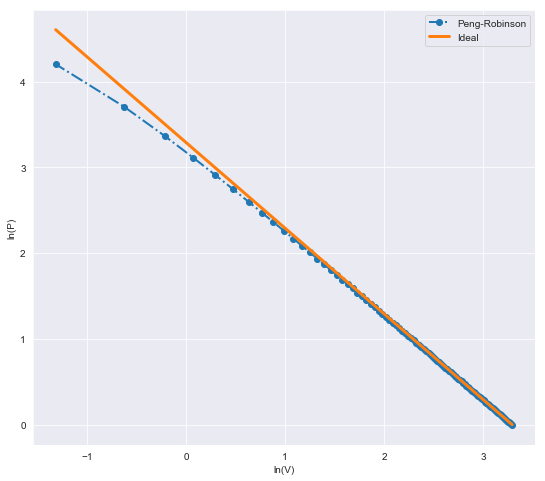

In [11]:
# de forma grafica
plt.figure(figsize=(9,8))
plt.plot(df['lnV'], df['lnP'], 'o', label='Peng-Robinson', lw=2, ls='-.')
plt.plot(df['lnV'], df['lnPid'], label='Ideal', lw=3)
plt.xlabel('ln(V)')
plt.ylabel('ln(P)')
plt.legend(loc='best')